# Scatter Plots - FUR

## Load Libraries

In [6]:
from obspy import UTCDateTime
from scipy.signal import welch
from tqdm import tqdm
from pathlib import Path

import os, sys
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# from andbro__store_as_pickle import __store_as_pickle

In [7]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [9]:
# ## ---------------------------------------

config = {}

## specify paths
config['path_to_figs'] = data_path+f"LNM2/figures/scatter/"

config['path_to_data'] = data_path+f"LNM2/data/"


## Methods

In [11]:
compl_FUR = pd.read_pickle(config['path_to_data']+"compliance_FUR.pkl")
compl_ROMY = pd.read_pickle(config['path_to_data']+"compliance_ROMY.pkl")

## Compliance Plot

In [14]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    scaling = 1

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(10, 5))

    ax.plot(compl['fc'], compl['Z']*scaling, label="FUR.Z")
    ax.plot(compl['fc'], compl['N']*scaling, label="FUR.N")
    ax.plot(compl['fc'], compl['E']*scaling, label="FUR.E")


    ax.grid(axis="both", ls=":", zorder=0)
    ax.legend(loc=1)

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(1e-3, 1e0)

    ax.set_xlabel("Frequency (Hz)", fontsize=font)
    ax.set_ylabel("Compliance (nm/s$^2$/hPa)", fontsize=font)

    plt.show();
    return fig

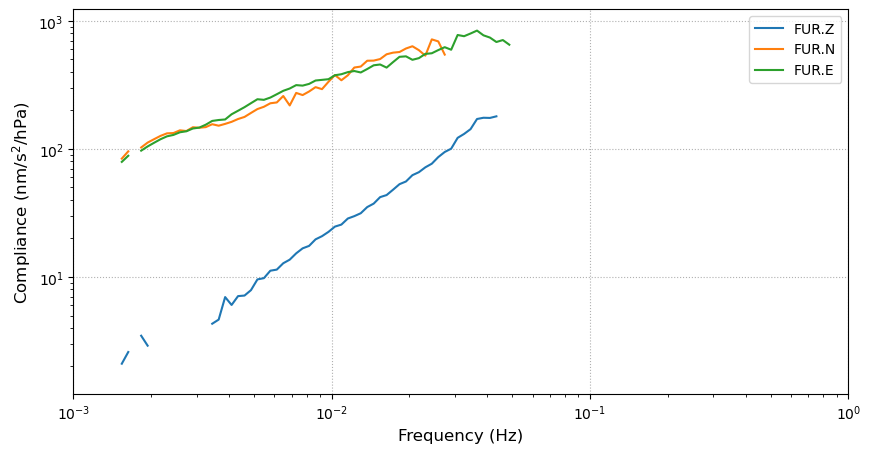

In [15]:
fig = __makeplot();

fig.savefig(config['path_to_figs']+f"FUR_compliance.png", format="png", dpi=150, bbox_inches='tight')


In [16]:
os.system("""spd-say "Finished" """)

0

In [17]:
from andbro__querrySeismoData import __querrySeismoData

WETR

NameError: name 'WETR' is not defined

In [ ]:
# _df2_high_coh = _df2[_df2.iloc[:, 3] > 0.8]

# _x_high_coh = np.log10(_df2_high_coh.iloc[:, 1])
# _y_high_coh = np.log10(_df2_high_coh.iloc[:, 2])

# x = np.linspace(min(_x_high_coh), max(_x_high_coh), 100)
# a, b = __compute_orthogonal_distance_regression(_x_high_coh, _y_high_coh, xerr=None, yerr=None, bx=None, by=None)

# plt.scatter(10**_x_high_coh, 10**_y_high_coh)
# plt.plot(10**(x), 10**(x*a+b))
# plt.xscale("log")
# plt.yscale("log")
# print(x)